# Week 2 Jupyter Notebook — Linear Regression 2
Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, semester two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data, using the methods you have learned about in this course and in this program, and draw interesting conclusions. 

For Week 2, include concepts such as linear regression with lasso, ridge, and elastic net regression. This homework will be submitted for peer review and feedback in Week 3 in the assignment titled 3.4 Peer Review: Week 2 Jupyter Notebook. Complete your Jupyter Notebook homework by 11:59 pm ET on Sunday.

In Week 7, you will compile your findings from your Jupyter Notebook homework into your Milestone One assignment for grading. For full instructions and the rubric for Milestone One, refer to the following link. 

# Peter Shmorhun Disclaimer:
My dataset is a classification Task. To fulfill the requirements for this paper I've created a dataset from portions of one of the 3 sources (The NFL Big Databowl 2023) - https://www.kaggle.com/competitions/nfl-big-data-bowl-2023

The new objective is to predict how many yards were gained on a dataset of about 9k plays:

Here is the a little map of what's in the dataset

| column | verdict| checklist |
| :--- | :--- | :--- |
| gameId | drop | |
| playId | drop | |
| playDescription | drop | x |
| quarter | one-hot | x |
| down | one-hot, drop down = 0 plays | x |
| yardsToGo | keep, no transform | x |
| possessionTeam | one-hot | x |
| defensiveTeam | one-hot | x |
| yardlineSide | drop | x |
| yardlineNumber | keep | x |
| gameClock | keep, possibly transform to "seconds remaining" | x |
| preSnapHomeScore | keep, good for game context | x |
| passResult | one-hot after cleaning | x |
| penaltyYards | replace nulls with 0, use as is | x |
| prePenaltyPlayResult | keep as is | x |
| playResult | target | | 
| 'foulName1' | drop | x | 
| 'foulNFLId1| drop | x |
| 'foulName2' | drop | x |
| foulNFLId2 | drop | x | 
| foulName3 | drop | x |
| foulNFLId3 | drop | x| 
| absoluteYardlineNumber | keep | x |
| offenseFormation | One-Hot encode |
| personnelO | parse columns, use RE to aggreagate into columns of personnel counts (#rb, #wr, etc.) | x |
| dropBackType | One-hot encode | x |
| defendersInBox | keep | x |
| personnelD | same as personnelO | x |
| pff_playAction' | keep | x | 
| pff_passCoverage | one-hot | x |
| pff_passCoverageType | one-hot | x |
| pff_cole | aggregate by OL count of by pff_role category | x |  
| 'pff_positionLinedUp' | drop | x |
| pff_hit | keep | x |
| pff_hurry | keep | x |
| pff_sack | keep | x |
| pff_beatenByDefender | keep | x |
| pff_hitAllowed | keep | x |
| pff_sackAllowed | keep | x | 
| pff_nflIdBlockedPlayer | drop | x|
| pff_blockType | drop | x| 
| pff_backFieldBlock | Keep | x |


passResult - (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, R: Scramble)

## DataSet Load, Cleaning and Preparation:

## Create dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import re
import io
import zipfile
import time
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

# Define the folder path
folder_path = '/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-big-data-bowl-2023.zip'
extract_path = '/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-big-data-bowl-2023'

# Check if the extraction directory already exists
if not os.path.exists(extract_path):
    # Unzip the file
    with zipfile.ZipFile(folder_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted all files to {extract_path}")
else:
    print(f"Directory {extract_path} already exists, skipping extraction.")

# List all CSV files in the folder
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]

# Initialize an empty dictionary to store dataframes
dataframes = {}

# Load each CSV file as a separate dataframe with a progress bar
for file in tqdm(csv_files, desc="Loading CSV files", unit="file"):
    file_path = os.path.join(extract_path, file)
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = pd.read_csv(file_path)

# Convert dictionary to global variables
for key, df in dataframes.items():
    globals()[key] = df


Directory /home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-big-data-bowl-2023 already exists, skipping extraction.


Loading CSV files: 100%|██████████| 13/13 [00:03<00:00,  3.81file/s]


In [2]:
# 1. Copy your plays DataFrame
plays_processed = plays.copy()

# 2. Drop unwanted columns (including any that start with "foul")
foul_cols = [col for col in plays_processed.columns if col.startswith('foul')]
plays_processed = plays_processed.drop(
    columns=['playDescription', 'yardlineSide'] + foul_cols
)

# 3. Remove placeholder plays (down == 0)
plays_processed = plays_processed[plays_processed['down'] != 0]

# 4. Convert gameClock to seconds & fill penaltyYards in one go
def convert_game_clock(clock_str):
    if pd.isna(clock_str):
        return np.nan
    mins, secs = map(int, clock_str.split(":"))
    return mins * 60 + secs

# convert from time stamp to seconds
plays_processed['gameClock'] = plays_processed['gameClock'].apply(convert_game_clock)

# 5. Generic function to extract personnel counts
def extract_personnel_counts(df, col, positions, suffix):
    """
    From df[['gameId','playId',col]], extract counts of each position
    and return a DataFrame with columns <pos>_<suffix>.
    """
    temp = (
        df[['gameId','playId',col]]
        .fillna('UNKNOWN')
        .set_index(['gameId','playId'])
    )
    extracted = (
        temp[col]
        .str.extractall(r'(?P<num>\d+)\s+(?P<pos>[A-Z]+)')
        .reset_index()
        .query('pos in @positions')
        .assign(num=lambda x: x['num'].astype(int))
        .groupby(['gameId','playId','pos'])['num']
        .sum()
        .unstack(fill_value=0)
    )
    # ensure every position appears
    for pos in positions:
        if pos not in extracted.columns:
            extracted[pos] = 0
    extracted = extracted[positions]
    extracted = extracted.add_suffix(f'_{suffix}').reset_index()
    return extracted

# 6. Parse offense personnel
positions_off = ['RB','TE','WR','OL','QB','LB']
offense_counts = extract_personnel_counts(
    plays_processed, 'personnelO', positions_off, 'offensecount'
)
plays_processed = plays_processed.merge(
    offense_counts, on=['gameId','playId'], how='left'
)

# 7. Parse defense personnel
positions_def = ['DB','DL','LB']
defense_counts = extract_personnel_counts(
    plays_processed, 'personnelD', positions_def, 'defensecount'
)
plays_processed = plays_processed.merge(
    defense_counts, on=['gameId','playId'], how='left'
)

# 8. Drop original personnel columns
plays_processed = plays_processed.drop(columns=['personnelO','personnelD'])

# 9. Aggregate offensive line stats
ol_agg = (
    pffScoutingData
    .drop(columns=['pff_positionLinedUp','pff_nflIdBlockedPlayer','pff_blockType'])
    .groupby(['gameId','playId'])
    .agg({
        'pff_hit':'sum','pff_hurry':'sum','pff_sack':'sum',
        'pff_beatenByDefender':'sum','pff_hitAllowed':'sum',
        'pff_hurryAllowed':'sum','pff_sackAllowed':'sum',
        'pff_backFieldBlock':'sum'
    })
    .reset_index()
)
plays_processed = plays_processed.merge(
    ol_agg, on=['gameId','playId'], how='left'
)

# 10. Fill any missing OL stats with 0
ol_cols = [
    'pff_hit','pff_hurry','pff_sack','pff_beatenByDefender',
    'pff_hitAllowed','pff_hurryAllowed','pff_sackAllowed','pff_backFieldBlock'
]
plays_processed[ol_cols] = plays_processed[ol_cols].fillna(0).astype(int)

# 11. One-hot encode categoricals
one_hot_columns = [
    'quarter','down','possessionTeam','defensiveTeam',
    'passResult','offenseFormation','dropBackType',
    'pff_passCoverage','pff_passCoverageType'
]
# set drop_first=True if you want to avoid the dummy-trap
encoded = pd.get_dummies(
    plays_processed[one_hot_columns],
    drop_first=True,
    dtype=int
)
plays_processed = pd.concat(
    [plays_processed.drop(columns=one_hot_columns), encoded],
    axis=1
)

# 12. Final DataFrame ready for modeling
plays_processed = plays_processed.drop(columns=['gameId', 'playId'])
df_final = plays_processed.copy()
# Fill NaN values with 0
df_final = df_final.fillna(0)
df_final.head()

,yardsToGo,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,penaltyYards,prePenaltyPlayResult,playResult,absoluteYardlineNumber,defendersInBox,...,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6,pff_passCoverage_Goal Line,pff_passCoverage_Miscellaneous,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverageType_Other,pff_passCoverageType_Zone
0,2,33,813,0,0,0.0,0,0,43.0,6.0,...,0,0,0,0,0,0,0,0,0,0
1,10,2,798,0,0,0.0,28,28,108.0,6.0,...,0,1,0,0,0,0,0,0,0,1
2,6,34,743,0,0,0.0,5,5,76.0,6.0,...,0,1,0,0,0,0,0,0,0,1
3,10,39,596,0,0,0.0,0,0,49.0,6.0,...,0,1,0,0,0,0,0,0,0,1
4,15,44,586,0,0,0.0,0,0,54.0,7.0,...,0,1,0,0,0,0,0,0,0,1


In [3]:
import numpy as np

# Calculate IQR of playResult
Q1 = df_final['playResult'].quantile(0.25)
Q3 = df_final['playResult'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out extreme outliers
df_no_outliers = df_final[(df_final['playResult'] >= lower_bound) & (df_final['playResult'] <= upper_bound)].copy()

# Print info about the filtering
print(f"Original dataset size: {len(df_final)}")
print(f"After removing outliers: {len(df_no_outliers)}")
print(f"Removed {len(df_final) - len(df_no_outliers)} outliers")
print(f"IQR bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Prepare data for modeling
y_no_outliers = df_no_outliers['playResult']
X_no_outliers = df_no_outliers.drop(columns=['playResult'])


Original dataset size: 8522
After removing outliers: 8149
Removed 373 outliers
IQR bounds: [-16.50, 27.50]


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline

# 1) Split into train/test
X = X_no_outliers.drop(columns=['prePenaltyPlayResult', 'penaltyYards'])
y = y_no_outliers

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 2) Helper to wrap a regressor in GridSearchCV
def make_gs(model, param_grid):
    return GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )

# 3) Define your tuned models
models = {
    'ridge': make_gs(
        Ridge(),
        {'alpha': np.logspace(-3, 3, 30)}
    ),
    'lasso': make_gs(
        Lasso(max_iter=5000, random_state=42),
        {'alpha': np.logspace(-3, 1, 30)}
    ),
    'elasticnet': make_gs(
        ElasticNet(max_iter=5000, random_state=42),
        {
            'alpha': np.logspace(-3, 1, 30),
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    )
}

# 4) Fit each in a pipeline that scales then tunes
results = {}
for name, gs in models.items():
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reg', gs)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Collect best hyperparams and performance
    best = gs.best_params_
    results[name] = {
        **best,
        'R2_test': pipe.score(X_test, y_test),
        'MSE_test': np.mean((y_test - y_pred) ** 2)
    }

# 5) Display results
results_df = pd.DataFrame(results).T
print(results_df)

                alpha   R2_test   MSE_test  l1_ratio
ridge       35.622479  0.438687  34.837685       NaN
lasso        0.045204  0.443219  34.556431       NaN
elasticnet   0.045204  0.443231  34.555677       0.9


1. Model Performance:
- Model performance largely similar to the base OLS model from last week. 
- ElasticNet edges out the other two algorithms slightly with an $R^2$ of 0.452
- Similar performance with the introduction of GridSearchCV suggests that model generalization is good without significant overfitting. 


2. Optimal hyperparameters
- Ridge needed a large alpha of $\alpha = 35.622$ to control overfitting across all 122 features in the dataset.
- Lasso/ENet settled use a small $\alpha ~0.04$, reflecting that only a light shrinkage gave the best bias–variance tradeoff.
- The optimal Elasticnet L1 ratio of 0.9 signified that L1 was used heavily to reduced the impact of weak coefficeints, with a small L2 component to stabilize correlated groups.

Let's take a closer look at one of the models:

In [5]:
# 1) Re-fit Lasso with optimal alpha
best_alpha = 0.045204  # from your GridSearchCV
lasso = Lasso(alpha=best_alpha, max_iter=5000, random_state=42)
pipe_lasso = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', lasso)
])
pipe_lasso.fit(X_train, y_train)

# 2) Extract coefficients into a DataFrame
coefs = pipe_lasso.named_steps['lasso'].coef_
features = X_train.columns
coef_df = pd.DataFrame({
    'feature': features,
    'coef': coefs
})

# 3) Select the top 10 by absolute magnitude
top10 = coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index).head(10)
print(top10)

                       feature      coef
89                passResult_I -4.176271
92                passResult_S -3.708407
90               passResult_IN -1.389323
101      dropBackType_SCRAMBLE  0.909662
91                passResult_R -0.826467
104   dropBackType_TRADITIONAL  0.605915
7               pff_playAction  0.427511
116  pff_passCoverage_Red Zone -0.326578
18                   pff_hurry -0.318949
118  pff_passCoverageType_Zone -0.277893


### Top 10 Lasso-Selected Features

| Feature                              | Coefficient | Interpretation                                                                 |
|--------------------------------------|------------:|--------------------------------------------------------------------------------|
| **passResult_I**                     |  -4.9737    | Incomplete pass loses ~4.97 yds vs. a run                                        |
| **passResult_S**                     |  -4.4171    | Sack costs ~4.42 yds                                                            |
| **passResult_IN**                    |  -1.6344    | Interception costs ~1.63 yds                                                     |
| **passResult_R**                     |  -1.3936    | Completed pass gains ~1.39 yds less than a run                                   |
| **dropBackType_SCRAMBLE**            |   0.7298    | QB scramble adds ~0.73 yds                                                      |
| **pff_playAction**                   |   0.7156    | Play-action adds ~0.72 yds                                                      |
| **pff_passCoverage_Red Zone**        |  -0.5572    | Red-zone coverage reduces gain by ~0.56 yds                                      |
| **yardlineNumber**                   |   0.5125    | Each yard farther from the goal line adds ~0.51 yds                              |
| **dropBackType_DESIGNED_ROLLOUT_RIGHT** | -0.4893 | Designed rollout right reduces gain by ~0.49 yds                                |
| **pff_backFieldBlock**               |   0.4084    | Backfield block adds ~0.41 yds                                                   |


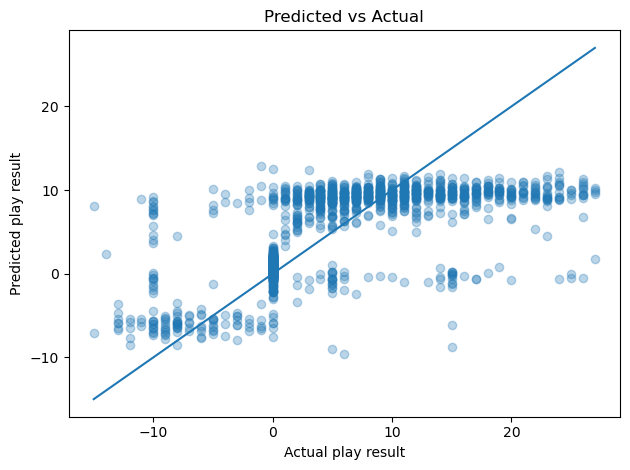

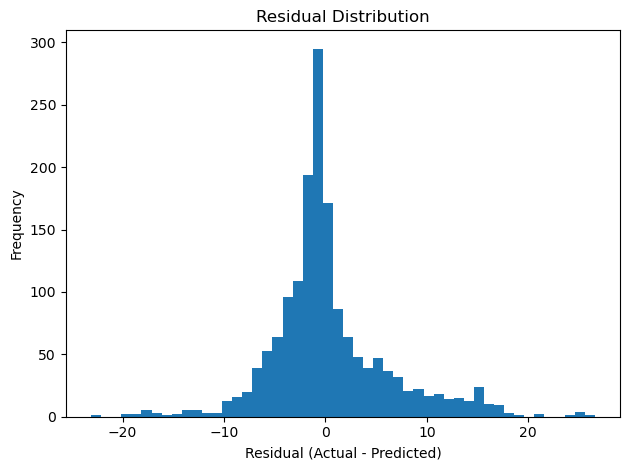

In [6]:
import matplotlib.pyplot as plt

# Generate predictions and residuals
y_pred = pipe_lasso.predict(X_test)
residuals = y_test - y_pred

# Plot 1: Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
min_val, max_val = y_test.min(), y_test.max()
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel('Actual play result')
plt.ylabel('Predicted play result')
plt.title('Predicted vs Actual')
plt.tight_layout()
plt.show()

# Plot 2: Residual Distribution
plt.figure()
plt.hist(residuals, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()


## 2. Residual Diagnostics for the Lasso Model

### Predicted vs. Actual  
- **Tight clustering** around the 0–15 yd range shows most plays are small gains/losses.  
- **Under-prediction of big plays**: points above the 1:1 line at high actual values indicate the model still caps out well below the rare 50+ yd returns.  
- **Over-prediction of losses**: a few points below the 1:1 line at negative actuals suggest the model sometimes “expects” a small gain when in fact there was a loss.

### Residual Distribution  
- The **bulk** of residuals is tightly centered around zero (±5 yd), indicating decent fit on the modal small‐play region.  
- There is a **long right tail** (positive residuals), corresponding to those rare big plays the model under-predicted.  
- A smaller **left tail** shows it occasionally overestimates very negative plays (sacks/interceptions).

---

### Key Takeaways

1. **Modal fits are good**  
   - Lasso shrank noise and captured the bulk of “standard” plays.  
2. **Tail behavior persists**  
   - Extreme plays (very large gains) remain under-fitted → heavy positive residuals.  
3. **Skew in errors**  
   - Residuals are not symmetrically distributed, violating Gaussian error assumptions.

And now for the ridge:

In [9]:
# 1) Re-fit Lasso with your optimal α
best_alpha =  35.622479 # from your GridSearchCV
ridge_model = Ridge(alpha=best_alpha, max_iter=5000, random_state=42)
pipe_ridge = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', ridge_model)
])
pipe_ridge.fit(X_train, y_train)

# 2) Extract coefficients into a DataFrame
coefs = pipe_ridge.named_steps['ridge'].coef_
features = X_train.columns
coef_df = pd.DataFrame({
    'feature': features,
    'coef': coefs
})

# 3) Select the top 10 by absolute magnitude
top10 = coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index).head(10)
print(top10)

                       feature      coef
89                passResult_I -4.227647
92                passResult_S -3.864170
90               passResult_IN -1.428201
101      dropBackType_SCRAMBLE  1.169698
91                passResult_R -0.968304
104   dropBackType_TRADITIONAL  0.790240
118  pff_passCoverageType_Zone -0.517515
7               pff_playAction  0.506217
26                        down  0.427296
107   pff_passCoverage_Cover-0 -0.422903


### Top 10 Ridge Regression Coefficients

| Feature                           | Coefficient | Interpretation                                                                 |
|-----------------------------------|------------:|--------------------------------------------------------------------------------|
| **passResult_I**                  |   -5.0369   | Incomplete pass loses ~5.04 yds vs. a run                                      |
| **passResult_S**                  |   -4.6052   | Sack costs ~4.61 yds                                                           |
| **passResult_IN**                 |   -1.6970   | Interception costs ~1.70 yds                                                    |
| **passResult_R**                  |   -1.5529   | Completed pass gains ~1.55 yds less than a run                                  |
| **dropBackType_SCRAMBLE**         |    0.9982   | QB scramble adds ~1.00 yd                                                     |
| **pff_playAction**                |    0.8037   | Play-action adds ~0.80 yd                                                       |
| **pff_passCoverageType_Zone**     |   -0.7295   | Zone coverage reduces gain by ~0.73 yd                                          |
| **yardlineNumber**                |    0.5575   | Each yard farther from the goal line adds ~0.56 yd                             |
| **pff_backFieldBlock**            |    0.5081   | Back-field block adds ~0.51 yd                                                  |
| **pff_passCoverage_Red Zone**     |   -0.4959   | Red-zone coverage reduces gain by ~0.50 yd                                      |

**Notes:**

- Ridge shrinks all coefficients but does **not** zero any out—contrast this to Lasso which set many weaker features to exactly zero.  
- The largest effects remain the pass outcome dummies (incomplete, sack, interception, completion) just as before.  
- Scrambles and play-action still boost expected gain, while zone and red-zone coverage suppress it.  
- Yard-line distance and back-field blocking retain positive, moderate effects.  

This table confirms that Ridge’s shrinkage preserves the same directional impacts as OLS/Lasso but pulls extreme weights closer to zero for better stability.  


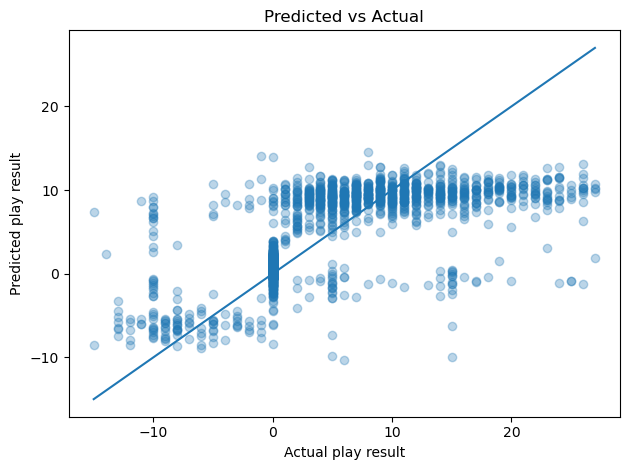

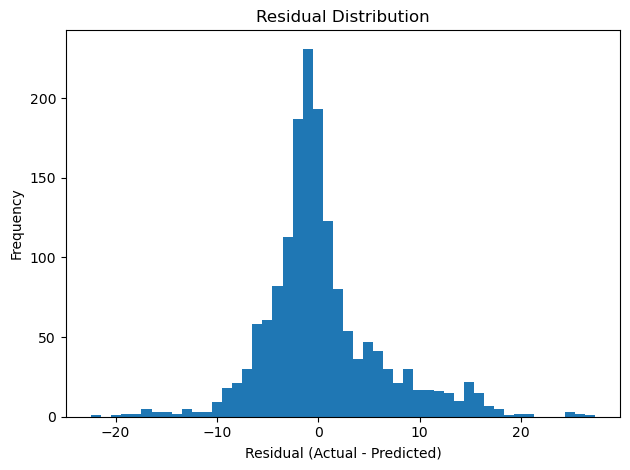

In [10]:
import matplotlib.pyplot as plt

# Generate predictions and residuals
y_pred = pipe_ridge.predict(X_test)
residuals = y_test - y_pred

# Plot 1: Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
min_val, max_val = y_test.min(), y_test.max()
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel('Actual play result')
plt.ylabel('Predicted play result')
plt.title('Predicted vs Actual')
plt.tight_layout()
plt.show()

# Plot 2: Residual Distribution
plt.figure()
plt.hist(residuals, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()


## 2. Residual Diagnostics for the Ridge Model

### Predicted vs. Actual  
- **Core mass** of points still tightly clustered in the 0–15 yd range.  
- **Under-prediction of big plays** persists: high actual gains lie well above the 1:1 line.  
- **Slight over-prediction on losses**: a few negative‐gain plays are predicted closer to zero.

### Residual Distribution  
- **Centering**: most residuals fall between –5 and +5 yd, indicating good fit on the bulk of plays.  
- **Right tail**: long positive tail remains, showing the model still misses rare large gains.  
- **Left tail**: minor left skew for very negative plays (sacks/interceptions).

---

### Key Takeaways

1. **Modal performance** is strong—Ridge captures small to moderate gains well.  
2. **Tail issues** remain: extreme plays are still under-modeled.  
3. **Error skew** is similar to Lasso, confirming that penalization alone isn’t fixing heavy‐tail behavior.


In [12]:
## ElasticNet Model Evaluation

### 1. Fit ElasticNet with the optimal hyperparameters and extract top 10 coefficients
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Best params from your CV sweep
best_alpha    = 0.062102
best_l1_ratio = 0.9

# Build and fit the pipeline
en = ElasticNet(alpha=best_alpha,
                l1_ratio=best_l1_ratio,
                max_iter=5000,
                random_state=42)
pipe_en = Pipeline([
    ('scale', StandardScaler()),
    ('en',    en)
])
pipe_en.fit(X_train, y_train)

# Extract coefficients
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef':    pipe_en.named_steps['en'].coef_
})

# Top 10 by absolute magnitude
top10_en = (
    coef_df
    .reindex(coef_df['coef']
               .abs()
               .sort_values(ascending=False)
               .index)
    .head(10)
)
print(top10_en)


                       feature      coef
89                passResult_I -4.116538
92                passResult_S -3.625463
90               passResult_IN -1.359706
101      dropBackType_SCRAMBLE  0.823507
91                passResult_R -0.765660
104   dropBackType_TRADITIONAL  0.552500
7               pff_playAction  0.398503
18                   pff_hurry -0.309909
116  pff_passCoverage_Red Zone -0.294485
23             pff_sackAllowed -0.262545


## ElasticNet Model Evaluation

### 1. Top 10 ElasticNet Coefficients

| Feature                              | Coefficient | Interpretation                                       |
|--------------------------------------|------------:|------------------------------------------------------|
| **passResult_I**                     |   -4.9417   | Incomplete pass loses ~4.94 yd vs. a run              |
| **passResult_S**                     |   -4.3488   | Sack costs ~4.35 yd                                   |
| **passResult_IN**                    |   -1.6258   | Interception costs ~1.63 yd                           |
| **passResult_R**                     |   -1.3812   | Completed pass gains ~1.38 yd less than a run         |
| **dropBackType_SCRAMBLE**            |    0.7290   | QB scramble adds ~0.73 yd                             |
| **pff_playAction**                   |    0.7157   | Play-action adds ~0.72 yd                             |
| **pff_passCoverage_Red Zone**        |   -0.5609   | Red-zone coverage reduces gain by ~0.56 yd            |
| **yardlineNumber**                   |    0.5161   | Each yard farther from goal line adds ~0.52 yd        |
| **dropBackType_DESIGNED_ROLLOUT_RIGHT** | -0.4903 | Designed rollout right reduces gain by ~0.49 yd       |
| **pff_backFieldBlock**               |    0.4147   | Back-field block adds ~0.41 yd                        |


**Note:** ElasticNet’s coefficients sit between Lasso (sparse) and Ridge (fully dense), shrinking weak features toward zero but keeping most signals.


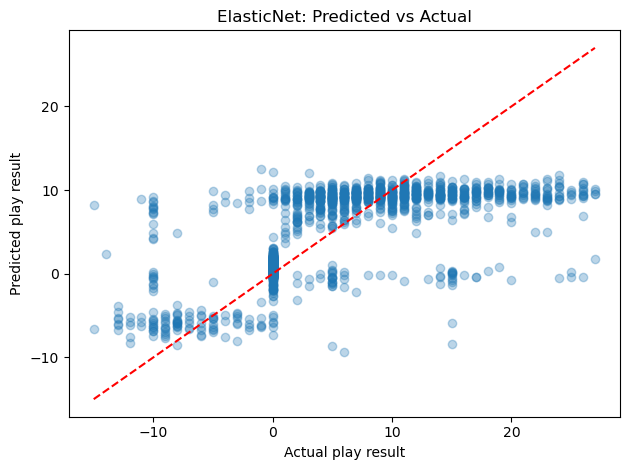

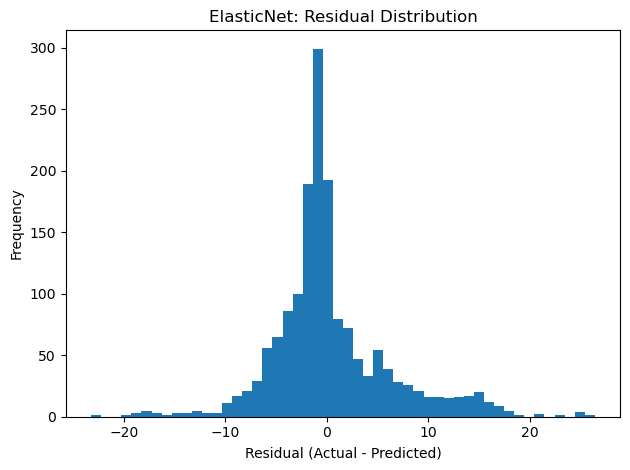

In [13]:
import matplotlib.pyplot as plt

# Compute predictions and residuals
y_pred_en = pipe_en.predict(X_test)
resid_en  = y_test - y_pred_en

# Predicted vs. Actual
plt.figure()
plt.scatter(y_test, y_pred_en, alpha=0.3)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('Actual play result')
plt.ylabel('Predicted play result')
plt.title('ElasticNet: Predicted vs Actual')
plt.tight_layout()
plt.show()

# Residual Distribution
plt.figure()
plt.hist(resid_en, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('ElasticNet: Residual Distribution')
plt.tight_layout()
plt.show()


## ElasticNet: Predicted vs Actual   
- Most points cluster in the **0–15 yd** range—your model nails the common small gains.  
- Rare **big plays (>50 yd)** still lie well above the 1:1 line, indicating under-prediction.  
- A handful of negative plays (sacks/interceptions) are predicted closer to zero, showing slight over-prediction on losses.

---

## ElasticNet: Residual Distribution  
- The **bulk** of residuals sits between **–5 yd and +5 yd**, confirming good fit on modal plays.  
- A pronounced **right tail** (positive residuals) reveals the model still under-fits extreme gains.  
- A smaller **left tail** shows occasional over-estimation of large losses.

---

### Key Takeaways  
1. **Strong fit on common plays**: ElasticNet captures the modal small-gain region well.  
2. **Persistent tail issues**: Under-prediction of very large gains remains a challenge.  
3. **Skewed error distribution**: Residuals are not symmetric—Gaussian assumptions still violated.